This notebook shows how to extract the estimated normalized entropy rate (nER) formulated in [Tejedor et al.](https://www.pnas.org/content/114/44/11651) from our channel network. The wikipage for the nER (without the discussion of the normalization factor) is [here](https://en.wikipedia.org/wiki/Entropy_rate).

In [1]:
import geopandas as gpd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
from orinoco import export_edges_to_geodataframe, export_nodes_to_geodataframe, dfs_line_search, direct_river_network_using_distance
import numpy as np
import scipy

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

In [4]:
plot_entropy = Path('plots/entropy')
plot_entropy.mkdir(exist_ok=True, parents=True)

# Obtain Directed Acyclic Network with Single Source

In [5]:
rivG = nx.read_gpickle(products_for_map_dir/'river_network.pkl')

Let's select the node with the label we want (easier to specify label than node from QGIS due to precision issues).

In [6]:
# labels are easier to obtain and unique
label_value = 361
nodes_with_label = [node for node, data in rivG.nodes(data=True) if data['label'] == label_value]
nodes_with_label[0], len(nodes_with_label)

((655447.4137931034, 3280608.908045977), 1)

Using this SO [post](https://stackoverflow.com/a/13934101/2348348) from the original author of NetworkX, we can obtain the relevant subgraph.

In [7]:
source_node = nodes_with_label[0]
downstream_nodes = list(nx.shortest_path(rivG, source_node).keys())
rivG_sub = rivG.subgraph([source_node] + downstream_nodes).copy()
# Because some noddes are no longer junctions, this ensures the segments correspond to the current graph.
rivG_sub = direct_river_network_using_distance(rivG_sub.to_undirected())

In [8]:
node_data = dict(rivG.nodes(data=True))
pos = {node: node for node in node_data.keys()}

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


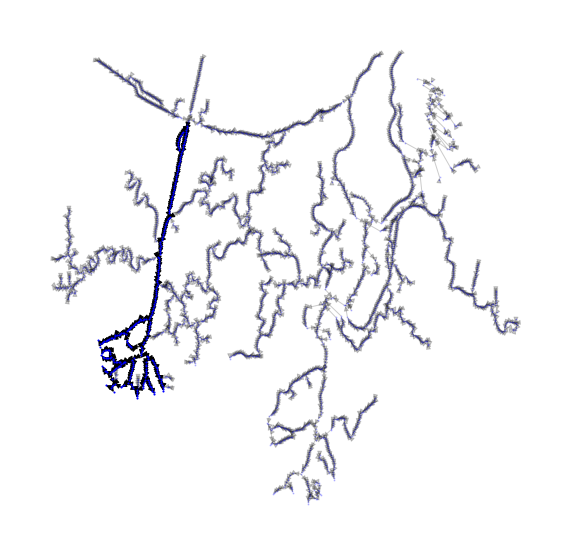

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(rivG, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        alpha=.2,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
nx.draw(rivG_sub, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
#ax.axis('on')
plt.savefig(plot_entropy/'subgraph.png')

# Merge at Junctions

In [10]:
width_dict = nx.get_edge_attributes(rivG, 'width_m')
weight_dict = nx.get_edge_attributes(rivG, 'weight')

The depth-first search lines searches by edges and yields a list of edges in a partition.

In [11]:
lines = list(dfs_line_search(rivG_sub, source_node))

In [12]:
edge_data_merged = {(line[0][0], line[-1][1], k):  {'segment_id': k,
                                                    # Average width along edge segment
                                                    'width': np.mean([width_dict[edge] for edge in line]),
                                                    # Total Length of Line
                                                    'weight': np.sum([weight_dict[edge] for edge in line])}
                     for (k, line) in enumerate(lines)

                    }
current_edge_index = len(lines)
current_edge_index

31

In [13]:
rivG_merged = nx.MultiDiGraph()
rivG_merged.add_edges_from(edge_data_merged.keys())
nx.set_edge_attributes(rivG_merged, edge_data_merged)

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


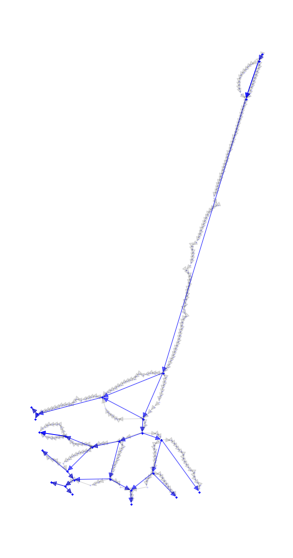

In [14]:
fig, ax = plt.subplots(figsize=(5, 10))
nx.draw(rivG_merged, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(rivG_merged.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')

nx.draw(rivG_sub, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        alpha=.1,
        node_color='blue')


# Connect Source and Outlets

In [15]:
outlets = [node for node in rivG_sub.nodes() if rivG_sub.out_degree(node)== 0]
len(outlets)

9

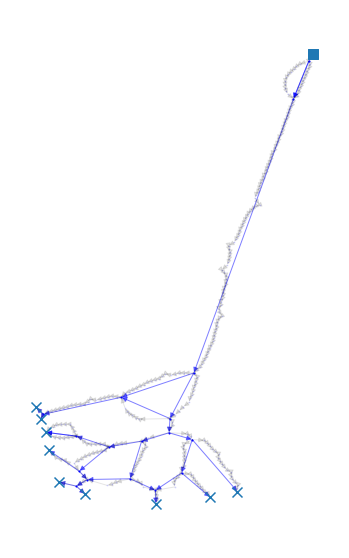

In [16]:
fig, ax = plt.subplots(figsize=(6, 10))

nx.draw(rivG_merged, 
        pos=pos, 
        node_size=1,
        edge_width=.45,
        edge_color=[(0, 0, 1, .5)]*len(rivG_merged.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')

nx.draw(rivG_sub, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        alpha=.1,
        node_color='blue')

nx.draw_networkx_nodes(rivG_sub.subgraph(outlets),
                       ax=ax,
                       pos=pos,
                       node_shape='x',
                       node_size=100)

nx.draw_networkx_nodes(rivG_sub.subgraph([source_node]),
                       ax=ax,
                       pos=pos,
                       node_shape='s',
                       node_size=100)
plt.savefig(plot_entropy/'multigraph.png')

In [17]:
stationary_distribution_graph = rivG_merged.copy()
edges_outlet_to_source = [(outlet, source_node, k + current_edge_index) 
                            for k, outlet in enumerate(outlets)]
stationary_distribution_graph.add_edges_from(edges_outlet_to_source)
nx.set_edge_attributes(stationary_distribution_graph,
                      {edge: {'width': 1.} for edge in edges_outlet_to_source})
current_edge_index = len(lines) + len(outlets)

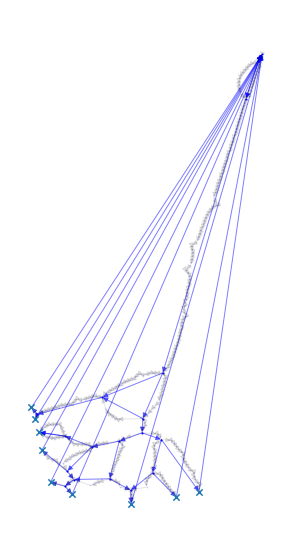

In [18]:
fig, ax = plt.subplots(figsize=(5, 10))

nx.draw(stationary_distribution_graph, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(stationary_distribution_graph.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')

nx.draw(rivG_sub, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        alpha=.1,
        node_color='blue')

nx.draw_networkx_nodes(rivG_sub.subgraph(outlets),
                       ax=ax,
                       pos=pos,
                       node_shape='x',
                       node_size=40)


# Compute Stationary Distribution and nER

In [19]:
nodes_from_multigraph = list(stationary_distribution_graph.nodes())

In [20]:
stationary_distribution_graph_undirected = stationary_distribution_graph.to_directed()
adj_mat = nx.adj_matrix(stationary_distribution_graph_undirected, 
                        nodelist=nodes_from_multigraph,
                        weight='width')
transition_matrix = np.array((adj_mat / adj_mat.sum(axis=1)))

In [21]:
import warnings

def compute_normalized_entropy_rate(transition_matrix):
    eig_values, eig_vec_l, _ = scipy.linalg.eig(transition_matrix, left=True)
    pi = eig_vec_l[:, 0].real
    pi = (pi / np.sum(pi))
    
    #enusre largest eignvalue is 1
    assert(np.abs(eig_values[0] - 1) < 1e-10)
    # ensure eigenvector is real
    assert(np.linalg.norm(eig_vec_l[:, 0].astype(float) - eig_vec_l[:, 0]) < 1e-10)
    
    log_T = np.log(transition_matrix, where=(transition_matrix>0), out=np.zeros(transition_matrix.shape))
    deg = np.sum((transition_matrix > 0), axis=1)
    normalized_er = np.einsum('ij,ij->i', transition_matrix, log_T) 
    normalized_er /=  np.log(1./deg, where=(deg > 1), out=np.ones(deg.shape))
    normalized_er = np.dot(normalized_er, pi)
    return normalized_er

In [22]:
compute_normalized_entropy_rate(transition_matrix)

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


0.3984824165822518